In [ ]:

!pip install -q lime opencv-python-headless scikit-learn matplotlib kagglehub

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import cv2

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import kagglehub
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")
DATA_PATH = os.path.join(path, "plantvillage dataset", "color")

Using Colab cache for faster access to the 'plantvillage-dataset' dataset.


In [ ]:
if os.path.exists(DATA_PATH):
    classes = sorted([d for d in os.listdir(DATA_PATH)
                      if os.path.isdir(os.path.join(DATA_PATH, d))])
    total_images = sum(
        len([f for f in os.listdir(os.path.join(DATA_PATH, c))
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        for c in classes
    )
    print(f"\n✅ Dataset found at: {DATA_PATH}")
    print(f"   Classes: {len(classes)}")
    print(f"   Total images: {total_images:,}")
    print(f"\n   First 5 classes:")
    for i, c in enumerate(classes[:5]):
        count = len(os.listdir(os.path.join(DATA_PATH, c)))
        print(f"     {i+1}. {c} ({count} images)")
    print(f"     ...")
else:
    print(f"❌ Path not found: {DATA_PATH}")
    print("   Try a different download method above.")


✅ Dataset found at: /kaggle/input/plantvillage-dataset/plantvillage dataset/color
   Classes: 38
   Total images: 54,305

   First 5 classes:
     1. Apple___Apple_scab (630 images)
     2. Apple___Black_rot (621 images)
     3. Apple___Cedar_apple_rust (275 images)
     4. Apple___healthy (1645 images)
     5. Blueberry___healthy (1502 images)
     ...


In [ ]:
IMG_SIZE = 128   # Paper uses 128x128
BATCH_SIZE = 16  # Paper uses batch size 16

# Data augmentation (paper uses flipping, rotation, Gaussian noise)
datagen = ImageDataGenerator(
    rescale=1.0 / 255,        # Normalize to [0, 1]
    rotation_range=30,         # Random rotation
    horizontal_flip=True,      # Random horizontal flip
    vertical_flip=True,        # Random vertical flip
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    validation_split=0.2       # 80% train, 20% validation
)

train_data = datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

NUM_CLASSES = train_data.num_classes
class_names = list(train_data.class_indices.keys())

print(f"\n✅ Data loaded successfully!")
print(f"   Training samples:   {train_data.samples:,}")
print(f"   Validation samples: {val_data.samples:,}")
print(f"   Number of classes:  {NUM_CLASSES}")

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.

✅ Data loaded successfully!
   Training samples:   43,456
   Validation samples: 10,849
   Number of classes:  38


# **Building the Mob-Res + SE attention Model**

In [ ]:
def se_block(input_tensor, ratio=16):
    """
    NOVELTY: Squeeze-and-Excitation (SE) Attention Block.

    1. SQUEEZE: Summarize each channel into a single number (via GAP)
    2. EXCITE:  Learn which channels are important (via 2 Dense layers)
    3. SCALE:   Re-weight the original features by importance
    """
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu',
                      kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid',
                      kernel_initializer='he_normal', use_bias=False)(se)

    return layers.multiply([input_tensor, se])


def residual_block(x, filters):
    """
    Standard residual block (same as original Mob-Res paper, Fig. 4):
      Conv2D(3x3) -> BN -> ReLU -> Conv2D(3x3) -> BN -> Add(shortcut) -> ReLU
    """
    shortcut = x

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def build_improved_mob_res(num_classes):
    """
    Improved Mob-Res model with SE-Attention fusion.
    """
    inputs = Input(shape=(128, 128, 3))

    # --- Path 1: Residual Learning ---
    p1 = residual_block(inputs, 64)
    p1 = layers.MaxPooling2D()(p1)         # 64x64x64
    p1 = residual_block(p1, 128)
    p1 = layers.MaxPooling2D()(p1)         # 32x32x128
    p1 = residual_block(p1, 256)            # 32x32x256
    p1 = layers.GlobalAveragePooling2D()(p1)  # -> 256
    p1 = layers.Reshape((1, 1, 256))(p1)

    # --- Path 2: MobileNetV2 (pre-trained, frozen) ---
    base_mob = MobileNetV2(input_shape=(128, 128, 3),
                           include_top=False,
                           weights='imagenet')
    base_mob.trainable = False
    p2 = base_mob(inputs)
    p2 = layers.GlobalAveragePooling2D()(p2)  # -> 1280
    p2 = layers.Reshape((1, 1, 1280))(p2)

    # --- Fusion with SE-Attention (NOVELTY) ---
    combined = layers.Concatenate()([p1, p2])  # -> (1, 1, 1536)
    combined = se_block(combined)               # SE attention re-weights features

    # --- Classification Head ---
    combined = layers.Flatten()(combined)
    outputs = layers.Dense(num_classes, activation='softmax')(combined)

    model = models.Model(inputs=inputs, outputs=outputs, name='Mob_Res_SE')
    return model


# Build the model
model = build_improved_mob_res(num_classes=NUM_CLASSES)
model.summary()

total_params = model.count_params()
print(f"\n✅ Mob-Res + SE-Attention model built!")
print(f"   Total parameters: {total_params:,}")
print(f"   (Original Mob-Res: 3,508,774 — SE block adds minimal overhead)")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Mob_Res_SE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        256 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 3,803,686 (14.51 MB)

 Trainable params: 1,543,014 (5.89 MB)

 Non-trainable params: 2,260,672 (8.62 MB)


✅ Mob-Res + SE-Attention model built!
   Total parameters: 3,803,686
   (Original Mob-Res: 3,508,774 — SE block adds minimal overhead)


# **Compile and Training the model**

In [ ]:
# Paper settings: Adam (beta1=0.9, beta2=0.9, lr=0.001), 40 epochs, early stopping

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.9
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'mob_res_se_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

#EPOCHS=40 for full research results
EPOCHS = 40

print("🚀 Starting Training...")
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

🚀 Starting Training...
Epoch 1/40
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9672 - loss: 0.1440
Epoch 1: val_accuracy improved from -inf to 0.91879, saving model to mob_res_se_best.keras
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 370s 130ms/step - accuracy: 0.9672 - loss: 0.1440 - val_accuracy: 0.9188 - val_loss: 0.6344
Epoch 2/40
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9683 - loss: 0.1390
Epoch 2: val_accuracy improved from 0.91879 to 0.96470, saving model to mob_res_se_best.keras
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 378s 131ms/step - accuracy: 0.9683 - loss: 0.1390 - val_accuracy: 0.9647 - val_loss: 0.1731
Epoch 3/40
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9665 - loss: 0.1494
Epoch 3: val_accuracy did not improve from 0.96470
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 340s 125ms/step - accuracy: 0.9665 - loss: 0.1494 - val_accuracy: 0.9521 - val_loss: 0.2321
Epoch 4/40
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9686 - loss: 0.1393
Epoch 4: val

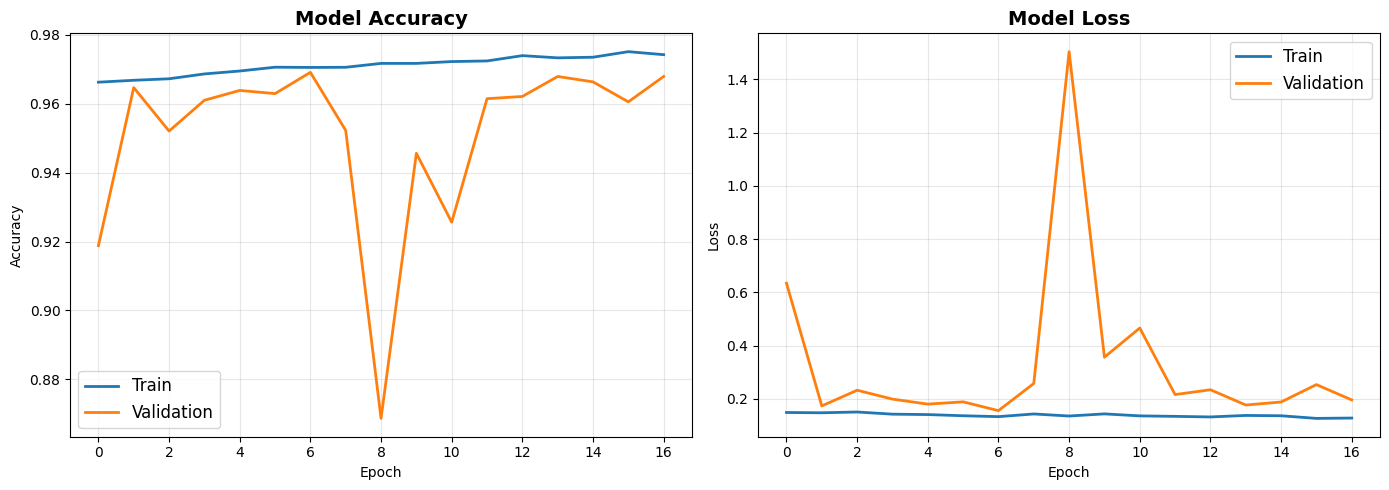

✅ Training curves saved to training_curves.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Training curves saved to training_curves.png")

In [ ]:
val_data.reset()
predictions = model.predict(val_data, verbose=1)
pred_classes = np.argmax(predictions, axis=1)
true_classes = val_data.classes

accuracy = np.mean(pred_classes == true_classes) * 100
print(f"\n🎯 Validation Accuracy: {accuracy:.2f}%")
print(f"   (Original Mob-Res reports 99.47% — compare with your SE version)")

print("\n📊 Classification Report:")
print(classification_report(
    true_classes, pred_classes,
    target_names=class_names,
    digits=4
))

679/679 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step

🎯 Validation Accuracy: 96.88%
   (Original Mob-Res reports 99.47% — compare with your SE version)

📊 Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.9826    0.8968    0.9378       126
                                 Apple___Black_rot     0.9915    0.9355    0.9627       124
                          Apple___Cedar_apple_rust     1.0000    0.9818    0.9908        55
                                   Apple___healthy     0.9781    0.9514    0.9646       329
                               Blueberry___healthy     0.9934    1.0000    0.9967       300
          Cherry_(including_sour)___Powdery_mildew     0.9858    0.9952    0.9905       210
                 Cherry_(including_sour)___healthy     0.9598    0.9824    0.9709       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.8936    0.8235    0.8571       102
  

Visualizing: /kaggle/input/plantvillage-dataset/plantvillage dataset/color/Apple___Apple_scab/5a178d63-372d-48c4-adb8-d616130ba3f0___FREC_Scab 3104.JPG


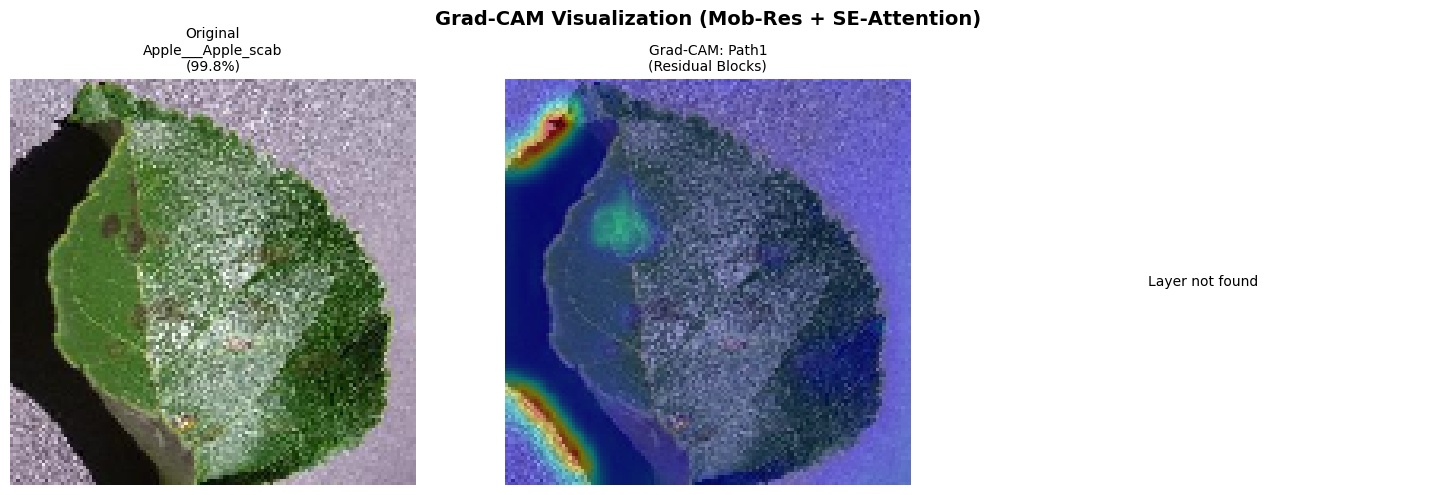

In [ ]:
def get_gradcam_heatmap(model, img_array, layer_name):
    """Generate Grad-CAM heatmap for a given layer."""
    grad_model = tf.keras.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        class_score = predictions[:, predicted_class]

    grads = tape.gradient(class_score, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(conv_outputs[0] * weights, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


def overlay_heatmap(image, heatmap, alpha=0.4):
    """Overlay heatmap on original image."""
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    overlay = np.float32(heatmap_colored) / 255 * alpha + np.float32(image) * (1 - alpha)
    return np.clip(overlay, 0, 1)


def visualize_gradcam(model, img_path, class_names):
    """Show Grad-CAM for both paths of Mob-Res + SE."""
    img = keras.utils.load_img(img_path, target_size=(128, 128))
    img_array = keras.utils.img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_input, verbose=0)
    pred_idx = np.argmax(pred[0])
    pred_name = class_names[pred_idx]
    confidence = pred[0][pred_idx] * 100

    # Find layers for Path1 (last activation in residual blocks) and Path2 (out_relu in MobileNetV2)
    path1_layer, path2_layer = None, None
    for layer in model.layers:
        if 'activation' in layer.name or 're_lu' in layer.name:
            path1_layer = layer.name
        if 'out_relu' in layer.name:
            path2_layer = layer.name

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_array)
    axes[0].set_title(f'Original\n{pred_name}\n({confidence:.1f}%)', fontsize=10)
    axes[0].axis('off')

    if path1_layer:
        hm = get_gradcam_heatmap(model, img_input, path1_layer)
        axes[1].imshow(overlay_heatmap(img_array, hm))
        axes[1].set_title('Grad-CAM: Path1\n(Residual Blocks)', fontsize=10)
    else:
        axes[1].text(0.5, 0.5, 'Layer not found', ha='center', va='center')
    axes[1].axis('off')

    if path2_layer:
        hm = get_gradcam_heatmap(model, img_input, path2_layer)
        axes[2].imshow(overlay_heatmap(img_array, hm))
        axes[2].set_title('Grad-CAM: Path2\n(MobileNetV2)', fontsize=10)
    else:
        axes[2].text(0.5, 0.5, 'Layer not found', ha='center', va='center')
    axes[2].axis('off')

    plt.suptitle('Grad-CAM Visualization (Mob-Res + SE-Attention)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('gradcam_result.png', dpi=150, bbox_inches='tight')
    plt.show()


# Auto-pick a sample image from the dataset
sample_class_dir = os.path.join(DATA_PATH, sorted(os.listdir(DATA_PATH))[0])
sample_img_path = os.path.join(sample_class_dir, os.listdir(sample_class_dir)[0])
print(f"Visualizing: {sample_img_path}")
visualize_gradcam(model, sample_img_path, class_names)

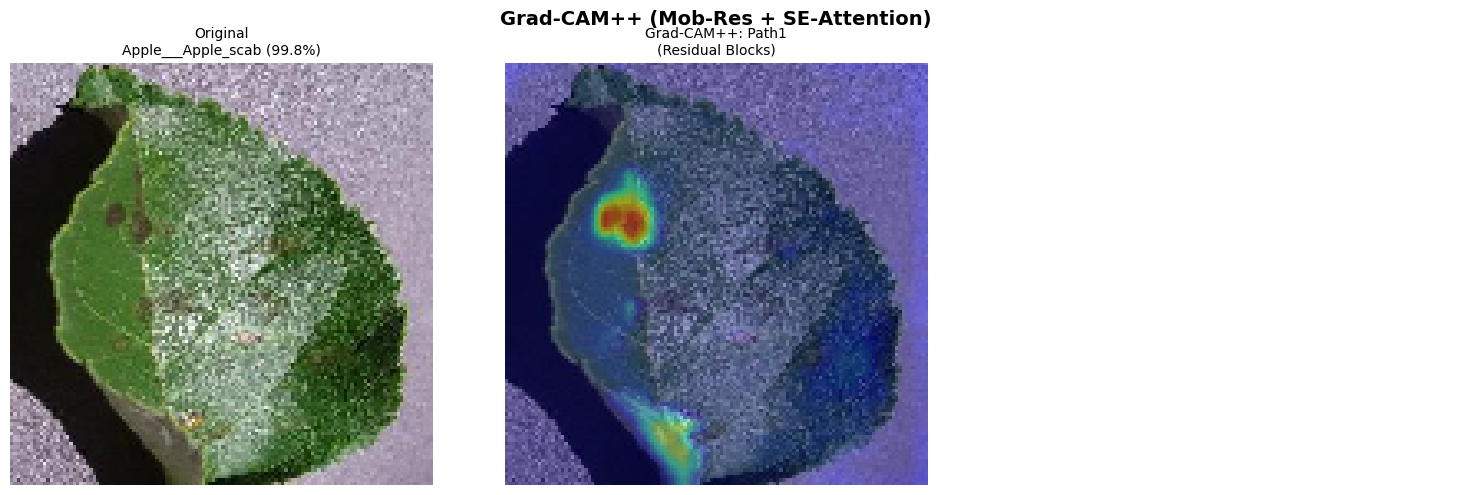

In [ ]:
def get_gradcampp_heatmap(model, img_array, layer_name):
    """Grad-CAM++ with higher-order gradients for precise localization."""
    grad_model = tf.keras.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_out, preds = grad_model(img_array)
                pred_class = tf.argmax(preds[0])
                score = preds[:, pred_class]
            g1 = tape3.gradient(score, conv_out)
        g2 = tape2.gradient(g1, conv_out)
    g3 = tape1.gradient(g2, conv_out)

    global_sum = tf.reduce_sum(conv_out[0], axis=(0, 1), keepdims=True)
    denom = 2.0 * g2[0] + global_sum * g3[0] + 1e-8
    alpha = g2[0] / denom
    alpha = tf.where(g1[0] > 0, alpha, tf.zeros_like(alpha))
    weights = tf.reduce_sum(alpha * tf.maximum(g1[0], 0), axis=(0, 1))
    heatmap = tf.reduce_sum(conv_out[0] * weights, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


def visualize_gradcampp(model, img_path, class_names):
    """Show Grad-CAM++ for both paths."""
    img = keras.utils.load_img(img_path, target_size=(128, 128))
    img_array = keras.utils.img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_input, verbose=0)
    pred_idx = np.argmax(pred[0])
    pred_name = class_names[pred_idx]
    conf = pred[0][pred_idx] * 100

    path1_layer, path2_layer = None, None
    for layer in model.layers:
        if 'activation' in layer.name or 're_lu' in layer.name:
            path1_layer = layer.name
        if 'out_relu' in layer.name:
            path2_layer = layer.name

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_array)
    axes[0].set_title(f'Original\n{pred_name} ({conf:.1f}%)', fontsize=10)
    axes[0].axis('off')

    if path1_layer:
        hm = get_gradcampp_heatmap(model, img_input, path1_layer)
        axes[1].imshow(overlay_heatmap(img_array, hm))
        axes[1].set_title('Grad-CAM++: Path1\n(Residual Blocks)', fontsize=10)
    axes[1].axis('off')

    if path2_layer:
        hm = get_gradcampp_heatmap(model, img_input, path2_layer)
        axes[2].imshow(overlay_heatmap(img_array, hm))
        axes[2].set_title('Grad-CAM++: Path2\n(MobileNetV2)', fontsize=10)
    axes[2].axis('off')

    plt.suptitle('Grad-CAM++ (Mob-Res + SE-Attention)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('gradcampp_result.png', dpi=150, bbox_inches='tight')
    plt.show()


visualize_gradcampp(model, sample_img_path, class_names)

  0%|          | 0/1000 [00:00<?, ?it/s]

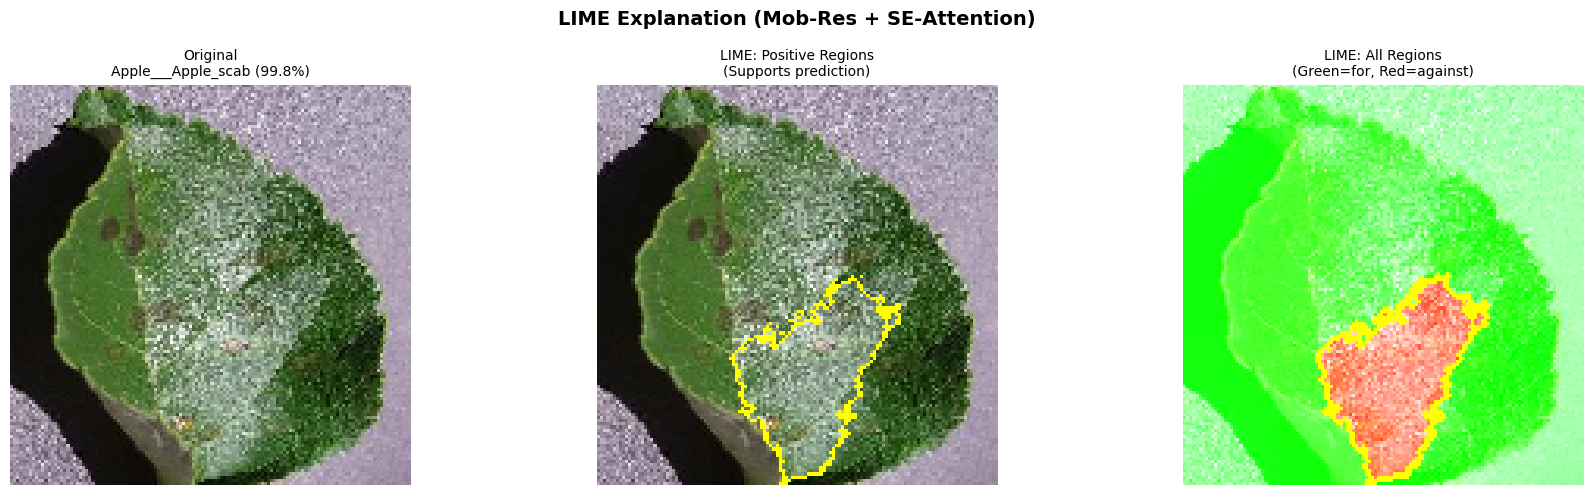

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries


def visualize_lime(model, img_path, class_names, num_samples=1000):
    """LIME explanation — shows which superpixels drive the prediction."""
    img = keras.utils.load_img(img_path, target_size=(128, 128))
    img_array = keras.utils.img_to_array(img) / 255.0

    pred = model.predict(np.expand_dims(img_array, axis=0), verbose=0)
    pred_idx = np.argmax(pred[0])
    pred_name = class_names[pred_idx]
    conf = pred[0][pred_idx] * 100

    explainer = lime_image.LimeImageExplainer()

    def predict_fn(images):
        return model.predict(images.astype(np.float32) / 255.0, verbose=0)

    explanation = explainer.explain_instance(
        (img_array * 255).astype(np.uint8),
        predict_fn,
        top_labels=5,
        hide_color=0,
        num_samples=num_samples
    )

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].imshow(img_array)
    axes[0].set_title(f'Original\n{pred_name} ({conf:.1f}%)', fontsize=10)
    axes[0].axis('off')

    temp, mask = explanation.get_image_and_mask(
        pred_idx, positive_only=True, num_features=10, hide_rest=False)
    axes[1].imshow(mark_boundaries(temp / 255.0, mask))
    axes[1].set_title('LIME: Positive Regions\n(Supports prediction)', fontsize=10)
    axes[1].axis('off')

    temp2, mask2 = explanation.get_image_and_mask(
        pred_idx, positive_only=False, num_features=10, hide_rest=False)
    axes[2].imshow(mark_boundaries(temp2 / 255.0, mask2))
    axes[2].set_title('LIME: All Regions\n(Green=for, Red=against)', fontsize=10)
    axes[2].axis('off')

    plt.suptitle('LIME Explanation (Mob-Res + SE-Attention)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('lime_result.png', dpi=150, bbox_inches='tight')
    plt.show()


visualize_lime(model, sample_img_path, class_names)

In [ ]:
# Saving the model
model.save('mob_res_se_final.keras')
print("✅ Model saved to mob_res_se_final.keras")

#To load later:
model = keras.models.load_model('mob_res_se_final.keras')
print("✅ Model loaded")

✅ Model saved to mob_res_se_final.keras
✅ Model loaded


# **Single image prediction (FOR DEMO)**


🌿 Plant Disease Prediction (Mob-Res + SE-Attention)
Image: 5a178d63-372d-48c4-adb8-d616130ba3f0___FREC_Scab 3104.JPG

Rank   Class                                      Confidence
------ ------------------------------------------ ----------
>>> 1. Apple___Apple_scab                        99.81%
    2. Soybean___healthy                          0.18%
    3. Apple___Black_rot                          0.00%
    4. Pepper,_bell___Bacterial_spot              0.00%
    5. Potato___Early_blight                      0.00%


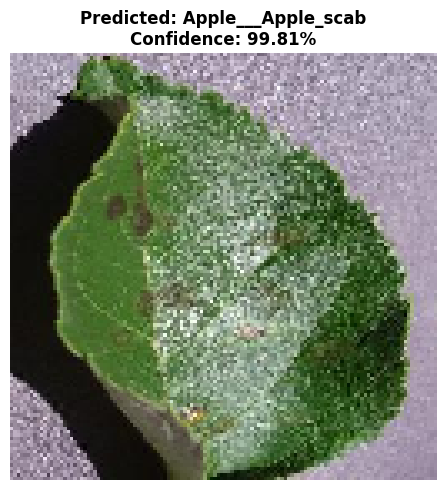

('Apple___Apple_scab', np.float32(0.99811506))

In [ ]:
def predict_disease(model, img_path, class_names):
    """Predict disease for a single leaf image with top-5 results."""
    img = keras.utils.load_img(img_path, target_size=(128, 128))
    img_array = keras.utils.img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_input, verbose=0)

    top5 = np.argsort(pred[0])[::-1][:5]

    print(f"\n🌿 Plant Disease Prediction (Mob-Res + SE-Attention)")
    print(f"{'='*60}")
    print(f"Image: {os.path.basename(img_path)}")
    print(f"\n{'Rank':<6} {'Class':<42} {'Confidence':>10}")
    print(f"{'-'*6} {'-'*42} {'-'*10}")
    for rank, idx in enumerate(top5, 1):
        marker = '>>>' if rank == 1 else '   '
        print(f"{marker} {rank}. {class_names[idx]:<40} {pred[0][idx]*100:>6.2f}%")

    plt.figure(figsize=(5, 5))
    plt.imshow(img_array)
    plt.title(f"Predicted: {class_names[top5[0]]}\n"
              f"Confidence: {pred[0][top5[0]]*100:.2f}%",
              fontsize=12, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return class_names[top5[0]], pred[0][top5[0]]


# Predict on a sample image
predict_disease(model, sample_img_path, class_names)